# Task2 SEAICE TRAINING AND TEST ——PART1

### 本任务的目的是通过SEAICE数据集的训练熟悉基于UNET网络语义分割流程。
1. 用函数式构建UNET网络
2. 熟悉数据处理到模型构建-训练-预测-保存整个过程


* step1 加载必要的库函数

In [1]:
# for tf2.0
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Dense, Activation, Conv2D,Input,MaxPooling2D,Dropout,BatchNormalization,Conv2DTranspose,UpSampling2D,ZeroPadding2D,concatenate
from keras.optimizers import RMSprop,Adam
import matplotlib.pyplot as plt
import glob
import time
from sklearn.model_selection import train_test_split
from skimage import io
from historycal import LossHistory
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,CSVLogger
from PIL import Image
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\envs\py36\lib\site-packag

* step2 加载数据并完成预处理

In [11]:
image_path = './sea_ice\\image\\'
mask_path = './sea_ice\\label\\'
result_path = './prediction\\'
target_size = (256,256)


In [41]:
# first of all check the image format,confirm the max value (uint8 0-255)
def Load_Color_Data(image_path, mask_path):
    image_name_arr = glob.glob(os.path.join(image_path,"*.jpg"))
    image_arr = []
    mask_arr = []
    
    for index,item in enumerate(image_name_arr):
        img = io.imread(item)
        # img=np.resize(img,(256,256))
        # img = np.reshape(img,img.shape + (1,))
        # print(item,item.replace(image_path,mask_path))
        mask = io.imread(item.replace(image_path,mask_path))
        # mask=np.resize(mask,(256,256))
        # mask = np.reshape(mask,img.shape  + (1,))
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        image_arr.append(img)
        mask_arr.append(mask)

    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr, mask_arr

def plot_func(data,label):
    fig=plt.figure(figsize=(25,5))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow(Image.fromarray(np.uint8((data[i,:,:,0])*255)))
    plt.show()
    fig=plt.figure(figsize=(25,5))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow((label[i,:,:,0]),cmap="gray")
    plt.show()

In [52]:
images, labels = Load_Color_Data(image_path, mask_path)
# images = np.reshape(images,images.shape + (1,))
labels = np.reshape(labels,labels.shape + (1,))
threshold=500
xtrain,xtest,ytrain,ytest=train_test_split(images[:threshold],labels[:threshold],test_size=0.3)
xval=images[threshold:]
yval=labels[threshold:]
print(xtrain.shape,xtest.shape,ytrain.shape,ytest.shape,xval.shape,yval.shape)

(350, 256, 256, 3) (150, 256, 256, 3) (350, 256, 256, 1) (150, 256, 256, 1) (200, 256, 256, 3) (200, 256, 256, 1)


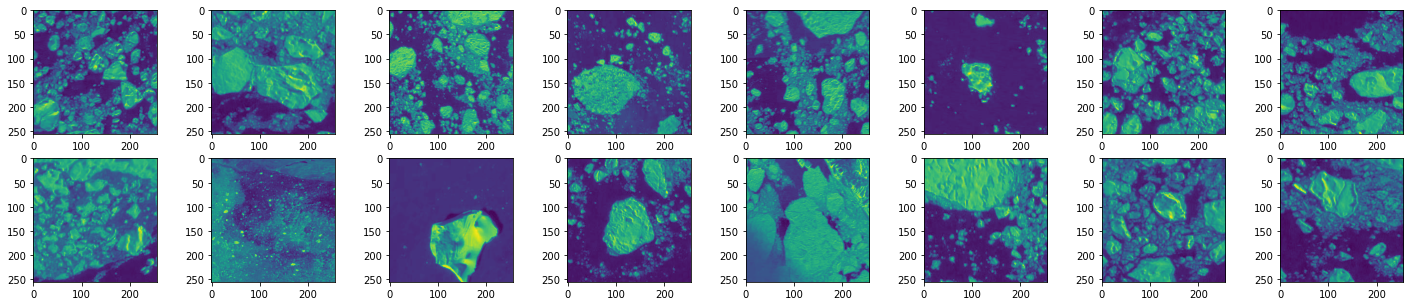

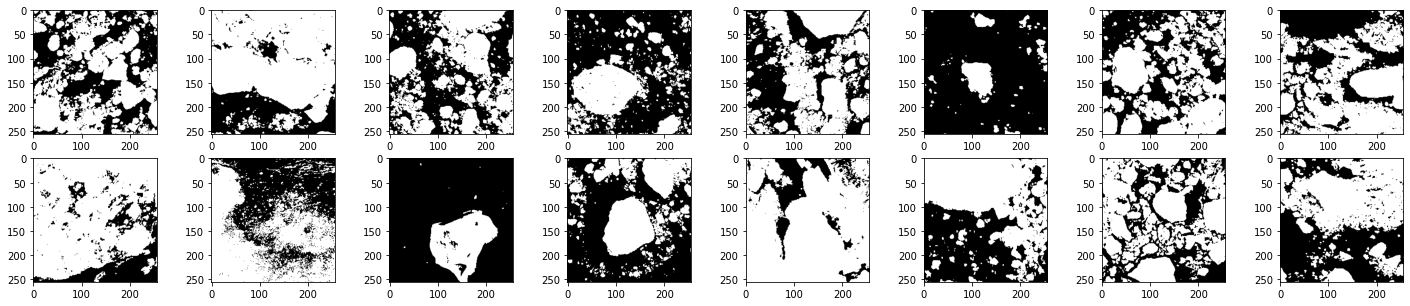

In [53]:
# Check whether the images are consistent with the labels
plot_func(xtrain,ytrain)

* step3 build UNET

In [54]:
def unet(input_size,optimizer,loss,metrics):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
#    merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
#    merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
#    merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
#    merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    # conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    outputs = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs,outputs)

    model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
    return model


* step4 setting hyper-params

In [59]:
loss='binary_crossentropy'
optimizer=Adam(lr=0.001)##SGD(),Adamax(),Adadelta()RAdam()
metrics=['accuracy']
input_height=256
input_width=256
nclass=1
nchannel=3
epoch=10
batch_size=40
nickname='unet'
input_size=(input_height,input_width,nchannel)
model=unet(input_size,optimizer,loss,metrics)
# model.summary()

* setp5 训练模型

In [60]:
begin_time = time.time()           
model_checkpoint = ModelCheckpoint(filepath="./checkpoint\\"+nickname+"-{epoch:02d}e-val_loss{val_loss:2f}.hdf5",monitor="val_loss",save_best_only=True,mode='auto')
histories=LossHistory()
# csvlogger =CSVLogger(filename="./checkpoint\\"+nickname+'-'+str(epoch)+'-log.csv', separator=',', append=False)
# result=model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epoch, verbose=1, shuffle=True,validation_data=(xtest, ytest),callbacks=[model_checkpoint,CSVLogger])
result=model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epoch, verbose=1, shuffle=True,validation_data=(xtest, ytest),callbacks=[model_checkpoint,histories])
end_time = time.time()
print('time lapsing {0} s \n'.format(end_time - begin_time))

Train on 350 samples, validate on 150 samples
Epoch 1/10
350/350 [==============================] - 50s 143ms/step - loss: 3.6265 - acc: 0.4708 - val_loss: 0.5897 - val_acc: 0.4888
Epoch 2/10
350/350 [==============================] - 49s 139ms/step - loss: 0.5211 - acc: 0.7428 - val_loss: 0.4324 - val_acc: 0.8469
Epoch 3/10
350/350 [==============================] - 57s 162ms/step - loss: 0.3678 - acc: 0.8523 - val_loss: 0.2515 - val_acc: 0.9129
Epoch 4/10
350/350 [==============================] - 56s 161ms/step - loss: 0.2338 - acc: 0.9146 - val_loss: 0.2101 - val_acc: 0.9225
Epoch 5/10
350/350 [==============================] - 59s 169ms/step - loss: 0.1710 - acc: 0.9383 - val_loss: 0.1763 - val_acc: 0.9338
Epoch 6/10
350/350 [==============================] - 61s 173ms/step - loss: 0.1540 - acc: 0.9405 - val_loss: 0.1628 - val_acc: 0.9373
Epoch 7/10
350/350 [==============================] - 63s 180ms/step - loss: 0.1443 - acc: 0.9433 - val_loss: 0.1495 - val_acc: 0.9412
Epoch 8/1

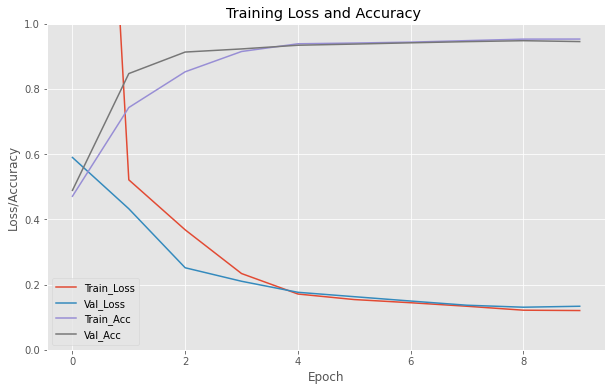

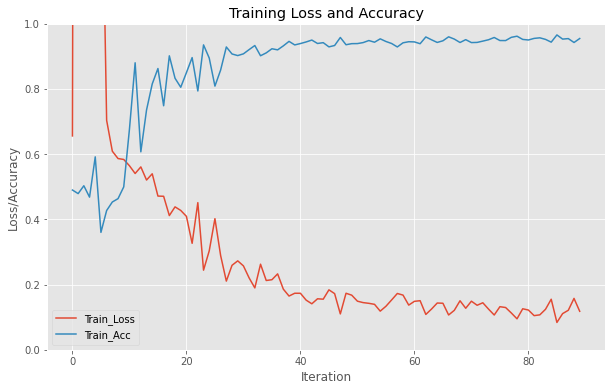

In [61]:
histories.loss_plot('epoch',nickname)
histories.loss_plot('batch',nickname)
h5_path ="./checkpoint\\"+nickname+"_train_history_"+str(epoch)+".h5"
histories.h5_save(h5_path)

200/200 [==============================] - 8s 40ms/step
0.13981486558914186 0.9440125942230224


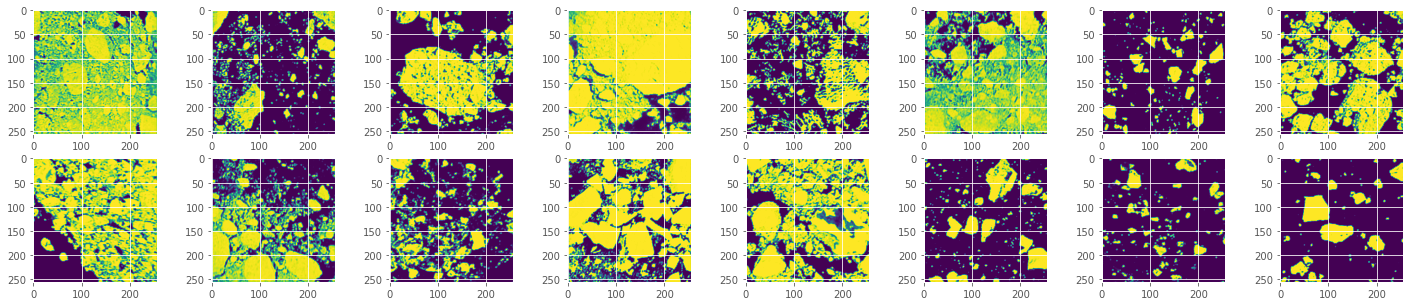

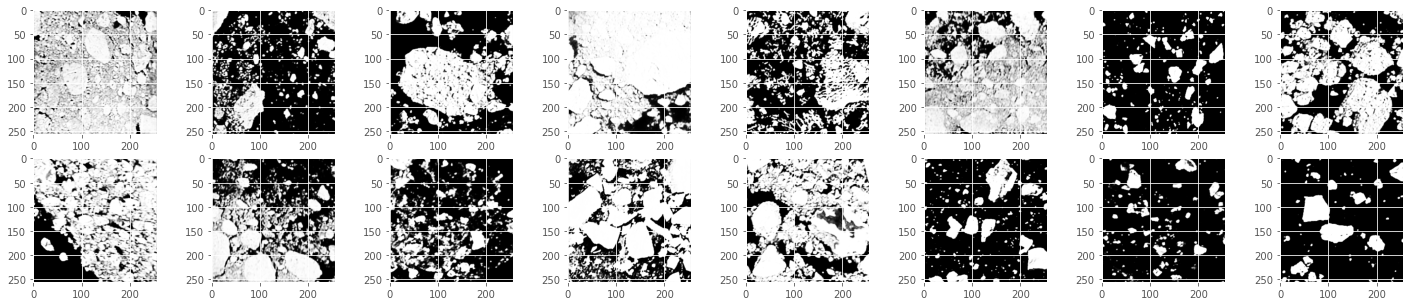

In [62]:
val_loss,val_acc=model.evaluate(x=xval,y=yval, batch_size=40, verbose=1)
print(val_loss,val_acc)
pred=model.predict(xval)
plot_func(pred,pred*255)